In [10]:
import pandas as pd
import statsmodels.api as sm    
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [5]:
base_path = '/myriadfs/projects/ICS_UKB/projects/kasia_project/causal_analysis/'
file_exposure = os.path.join(base_path, 'group_1_clean_filtered_imputed_dataset_df.tsv') # exposure variables 
file_outcome = os.path.join(base_path, 'group_1_outcomes_df_without_qc_df.tsv') # outcome variables 

exposure_data = pd.read_csv(file_exposure, sep='\t') 
outcome_data = pd.read_csv(file_outcome, sep='\t')

print(f'exposure_data shape: {exposure_data.shape}')
print(f'outcome_data shape: {outcome_data.shape}')

exposure_outcome_data = pd.merge(exposure_data, outcome_data, on='eid', how='inner') # merge exposure and outcome data on 'eid' column
print(f'Merged data shape: {exposure_outcome_data.shape}')

exposure_data shape: (459142, 415)
outcome_data shape: (459142, 8)
Merged data shape: (459142, 422)


In [6]:
df_model = exposure_outcome_data.copy()

raw_cols = [
    '1289-0.0', '1309-0.0', # Diet
    '864-0.0', '884-0.0',   # Activity
    '1050-0.0', '1060-0.0', # Sun
    '1160-0.0',             # Sleep
    '20116-0.0',            # Smoking
    '20117-0.0',            # Alcohol
    '1110-0.0', '2237-0.0', # Electronic
    '2090-0.0', '2040-0.0'  # Mental
]
existing_cols = [i for i in raw_cols if i in df_model.columns] # if column exists in df_model
for col in existing_cols:
    df_model[col] = df_model[col].apply(lambda x: np.nan if x < 0 else x)    

# 1289-0.0: vegetable intake, 1309-0.0: fruit intake
if '1289-0.0' in df_model.columns and '1309-0.0' in df_model.columns: 
    df_model['diet_total'] = df_model['1289-0.0'] + df_model['1309-0.0'] # diet_total = vegetable + fruit    

# 864-0.0: walk activity, 884-0.0: moderate activity
if '864-0.0' in df_model.columns and '884-0.0' in df_model.columns: 
    df_model['activity_is_active'] = ((df_model['864-0.0'] >= 5) | (df_model['884-0.0'] >= 5)).astype(int) # activity_is_active = 1 if walk or moderate activity >= 5 days/week, else 0

# 1050-0.0: summer sun exposure, 1060-0.0: winter sun exposure
if '1050-0.0' in df_model.columns and '1060-0.0' in df_model.columns:
    df_model['sun_exposure_avg'] = (df_model['1050-0.0'] + df_model['1060-0.0']) / 2 # sun_exposure_avg = average of summer and winter sun exposure

# 1160-0.0: sleep duration
if '1160-0.0' in df_model.columns:
    df_model['sleep_hours'] = df_model['1160-0.0']
    # sleep_abnormal = 1 if sleep_hours < 7 or sleep_hours > 8, else 0
    df_model['sleep_abnormal'] = df_model['1160-0.0'].apply(lambda x: 0 if 7 <= x <= 8 else 1)

# 20116-0.0: smoking status
if '20116-0.0' in df_model.columns:
    df_model['smoking_status'] = df_model['20116-0.0'] # smoking_status

# 20117-0.0: alcohol status
if '20117-0.0' in df_model.columns:
    df_model['alcohol_status'] = df_model['20117-0.0'] # alcohol_status    

# electronic device, mental and BMI (keep same as original)
other_cols = {
    'device_mobile':'1110-0.0', # mobile phone use
    'device_computer':'2237-0.0', # computer use
    'mental_doctor':'2090-0.0', # doctor visit
    'mental_risk':'2040-0.0', # risk taking
    'BMI':'21001-0.0' # BMI
}

for new_name, old_name in other_cols.items():
    if old_name in df_model.columns:
        df_model[new_name] = df_model[old_name]

# 'activity_is_active', 'sun_exposure_avg','alcohol_status' missing, so not included in feature_cols for now

feature_cols = ['diet_total',  
                'sleep_hours', 'smoking_status',
                'device_mobile', 'device_computer', 'mental_doctor', 'mental_risk'] # feature columns

print(feature_cols)


['diet_total', 'sleep_hours', 'smoking_status', 'device_mobile', 'device_computer', 'mental_doctor', 'mental_risk']


In [7]:
target_col = 'def_CVD_AFTER'
model_cols = ['age_defined_baseline', 'genetic_sex','BMI'] + feature_cols # age, sex, BMI + feature columns

# clean data for modeling
model_data = df_model[[target_col] + model_cols].dropna()

Y = model_data[target_col] # outcome variable
X = model_data[model_cols] # exposure variables
X = sm.add_constant(X) # add intercept

logit_model = sm.Logit(Y, X).fit() # fit the logistic regression model

print(logit_model.summary())

# calculate odds ratios and confidence intervals
print("\n=== (Odds Ratios) ===")
params = logit_model.params
conf = logit_model.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'Odds Ratio']

result_table = np.exp(conf)
result_table['P-value'] = logit_model.pvalues
print(result_table.sort_values(by='P-value',ascending=False))

Optimization terminated successfully.
         Current function value: 0.208296
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          def_CVD_AFTER   No. Observations:               429116
Model:                          Logit   Df Residuals:                   429105
Method:                           MLE   Df Model:                           10
Date:                Wed, 18 Feb 2026   Pseudo R-squ.:                 0.07287
Time:                        15:17:27   Log-Likelihood:                -89383.
converged:                       True   LL-Null:                       -96408.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -9.0919      0.085   -106.921      0.000      -9.259      -8.925

Total samples: 429116, Training samples: 343292, Testing samples: 85824
Testing AUC Score: 0.7144
Training AUC Score: 0.7143


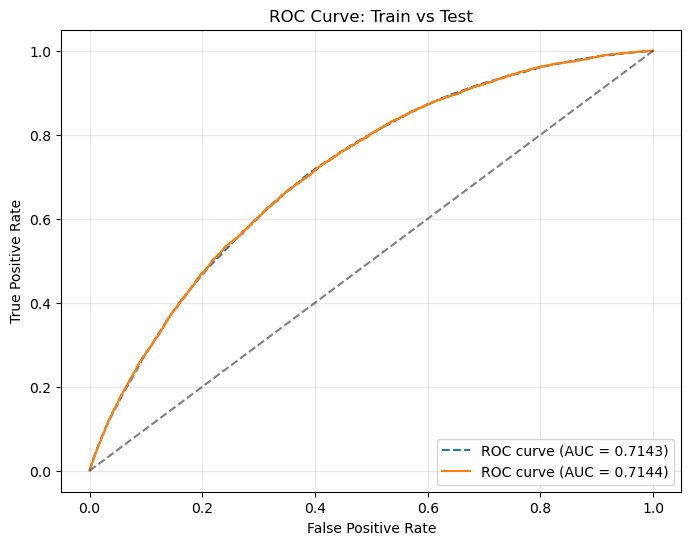

In [14]:
data_split = df_model[[target_col] + model_cols].dropna() # drop rows with missing values in target and model columns   

X1 = data_split[model_cols] # features
Y1 = data_split[target_col] # target variable   

X1 = sm.add_constant(X1) # add intercept
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.2, random_state=42) # split into train and test sets

print(f'Total samples: {len(data_split)}, Training samples: {len(X_train)}, Testing samples: {len(X_test)}')

model = sm.Logit(Y_train, X_train).fit(disp = 0) # fit model on training data

y_test_prob = model.predict(X_test) # predict probabilities on test set
y_train_prob = model.predict(X_train) # predict probabilities on training set

auc_test = roc_auc_score(Y_test, y_test_prob) # calculate AUC score for testing set
auc_train = roc_auc_score(Y_train, y_train_prob) # calculate AUC score for training set
print(f'Testing AUC Score: {auc_test:.4f}')
print(f'Training AUC Score: {auc_train:.4f}')

fpr_test, tpr_test, thresholds = roc_curve(Y_test, y_test_prob) # calculate false positive rate and true positive rate for testing ROC curve
fpr_train, tpr_train, thresholds = roc_curve(Y_train, y_train_prob) # calculate false positive rate and true positive rate for training ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, linestyle = '--', label=f'ROC curve (AUC = {auc_train:.4f})') # plot training ROC curve
plt.plot(fpr_test, tpr_test, linestyle = '-', label=f'ROC curve (AUC = {auc_test:.4f})') # plot testing ROC curve
plt.plot([0, 1], [0, 1], 'k--', alpha = 0.5) # plot diagonal line for reference
plt.xlabel('False Positive Rate') # label x-axis
plt.ylabel('True Positive Rate') # label y-axis
plt.title('ROC Curve: Train vs Test') # title for the plot
plt.legend(loc='lower right') # show legend
plt.grid(True,alpha=0.3) # add grid
plt.show() # display the plot

In [19]:
print(f'train mean: {Y_train.mean():.4f}')
print(f'test mean: {Y_test.mean():.4f}')
print(f'total mean: {Y1.mean():.4f}')
print(f'train prob mean: {y_train_prob.mean():.4f}')
print(f'test prob mean : {y_test_prob.mean():.4f}')
print(f'train prob std: {y_train_prob.std():.4f}')
print(f'test prob std: {y_test_prob.std():.4f}')

train mean: 0.0595
test mean: 0.0577
total mean: 0.0592
train prob mean: 0.0595
test prob mean : 0.0592
train prob std: 0.0452
test prob std: 0.0448
